<a href="https://colab.research.google.com/github/isabellaecheverri/NumCalc/blob/main/Lecture09/notebooks/L09_CNN_Transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de Aprendizaje en el Conjunto de Datos Caltech101

En este cuaderno, consideraremos un conjunto de datos más complejo que MNIST o CIFAR10. Las imágenes en Caltech101 son imágenes RGB (3 canales) con tamaño variable. Hay 101 clases diferentes. Intentaremos una práctica muy común en visión por computadora en la actualidad: transferencia de aprendizaje desde un modelo preentrenado en ImageNet.

## Plan de Trabajo:
- Modificar la red del ejercicio anterior (CIFAR-10) para trabajar con imágenes de 224x224.
- Entrenar el modelo por un tiempo en Caltech101 y ver qué tan lejos podemos llegar.
- Tomar un ResNet34 que fue preentrenado en ImageNet-1k y ajustarlo a Caltech101.
  - Considerar tanto entrenar solo la cabeza (el clasificador lineal al final de la red) como toda la red.
  - Deberíamos poder alcanzar un mejor rendimiento que nuestra red original en menos pasos de entrenamiento.
- Opcional: experimentar con otros modelos preentrenados de `timm` (ver información [aquí](https://github.com/rwightman/pytorch-image-models)).

## Preliminares

In [5]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

sns.set_style("whitegrid")

!pip install timm
import timm

def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

## Configuración de la base de datos

In [6]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
default_imagenet_normalization = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.25, 1)),  # crop of random size and aspect ratio, resize to square
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    default_imagenet_normalization,
])
test_transform = transforms.Compose([
    transforms.Resize(224),  # keep aspect ratio
    transforms.CenterCrop(224),  # square crop
    transforms.ToTensor(),
    default_imagenet_normalization,
])

batch_size = 64  # both for training and testing

# Load dataset (downloaded automatically if missing).
dataset = torchvision.datasets.Caltech101(root='./data', download=True)


def translate_label(y, keep_classes):
    try:
        return keep_classes.index(y)
    except ValueError:
        return -1


# Filter images such that no class has more than 100 examples.
# Loop through dataset in random order, include each image (its index) only if there are
# fewer than 100 images of the same class.
# Here we also remove the classes "Faces" and "Faces_easy".
skip_classes = [0, 1]   # "Faces" and "Faces_easy"
keep_classes = [c for c in range(len(dataset.categories)) if c not in skip_classes]
indices = list(range(len(dataset)))
random.shuffle(indices)
new_indices = []
current_class_size = {class_number: 0 for class_number in np.unique(dataset.y)}
for i in indices:
    class_number = dataset.y[i]
    if class_number not in skip_classes and current_class_size[class_number] < 100:
        new_indices.append(i)
        current_class_size[class_number] += 1
indices = new_indices

# Compute subset of labels given new indices selection
labels = [translate_label(dataset.y[i], keep_classes) for i in indices]
assert max(labels) == 98

test_size = 640
train_size = len(indices) - test_size
train_idx, test_idx = train_test_split(
    indices,
    train_size=train_size,
    test_size=test_size,
    shuffle=True,
    random_state=42,  # always get the same split
    stratify=labels,
)

class DatasetWithTransform(Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else list(range(len(dataset)))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the actual dataset index
        actual_idx = self.indices[idx]
        x, y = self.dataset[actual_idx]

        # Convert PIL image to RGB
        x = x.convert('RGB')

        # Apply transformations if provided
        if self.transform is not None:
            x = self.transform(x)

        # Translate the label
        y = translate_label(y, keep_classes)

        return x, y

In [7]:
train_set = DatasetWithTransform(dataset, train_idx, train_transform)
test_set = DatasetWithTransform(dataset, test_idx, test_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

### Un Vistazo Más Cercano al Conjunto de Datos

Primero, trazamos el tamaño de cada clase y observamos que la distribución de clases no es uniforme.

Luego, mostramos ejemplos aleatorios del conjunto de datos, anotados con la etiqueta de la clase y el índice.
Ten en cuenta que las imágenes de entrenamiento incluyen aumentos estándar que se utilizan típicamente en modelos de visión (definidos anteriormente).


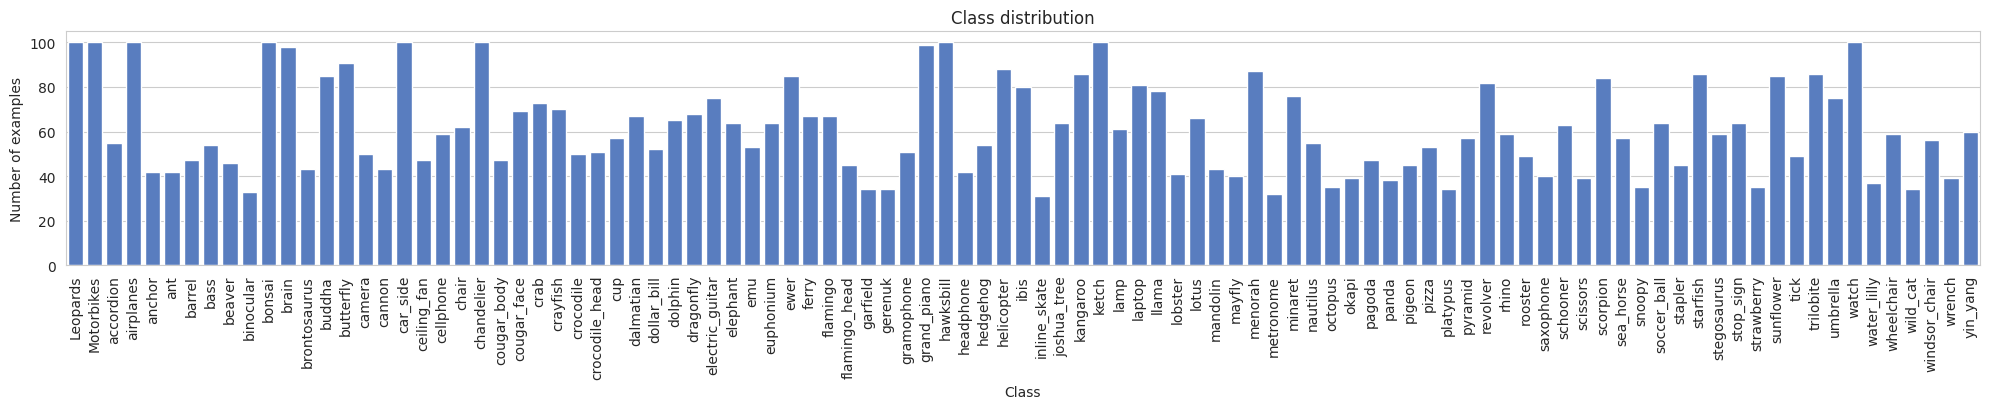



Train images (including augmentations):


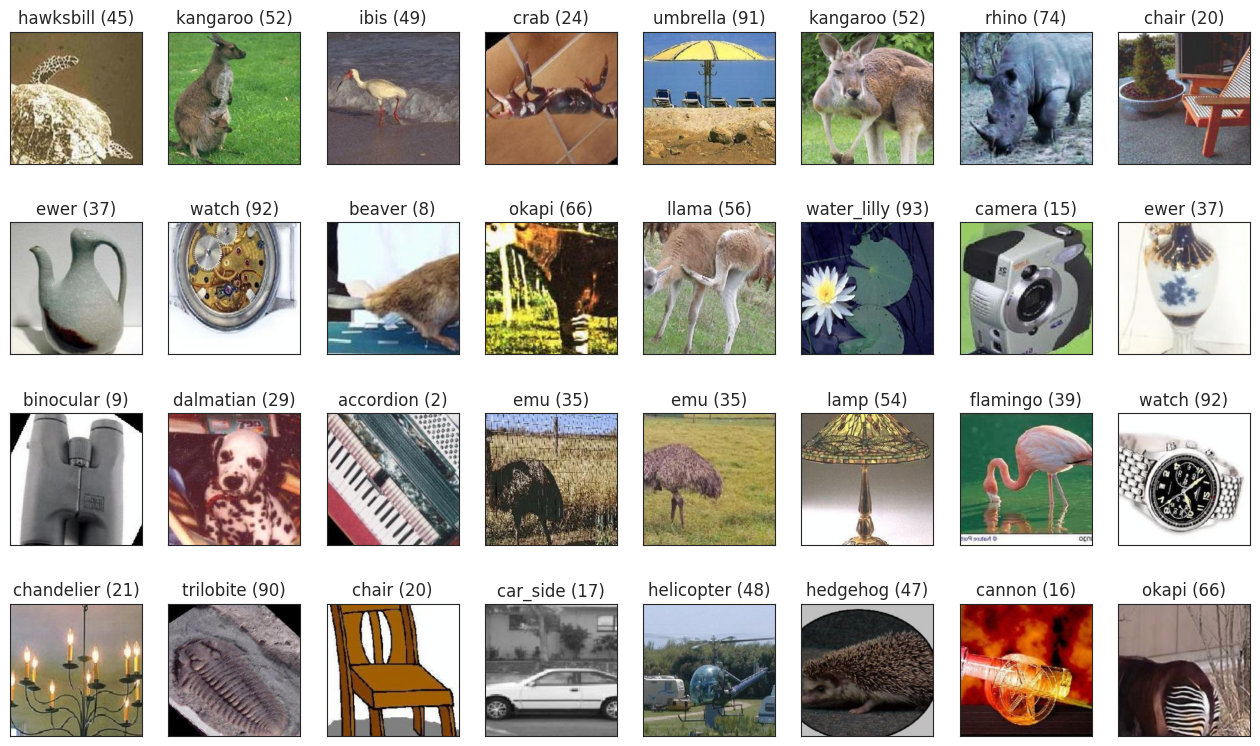



Test images:


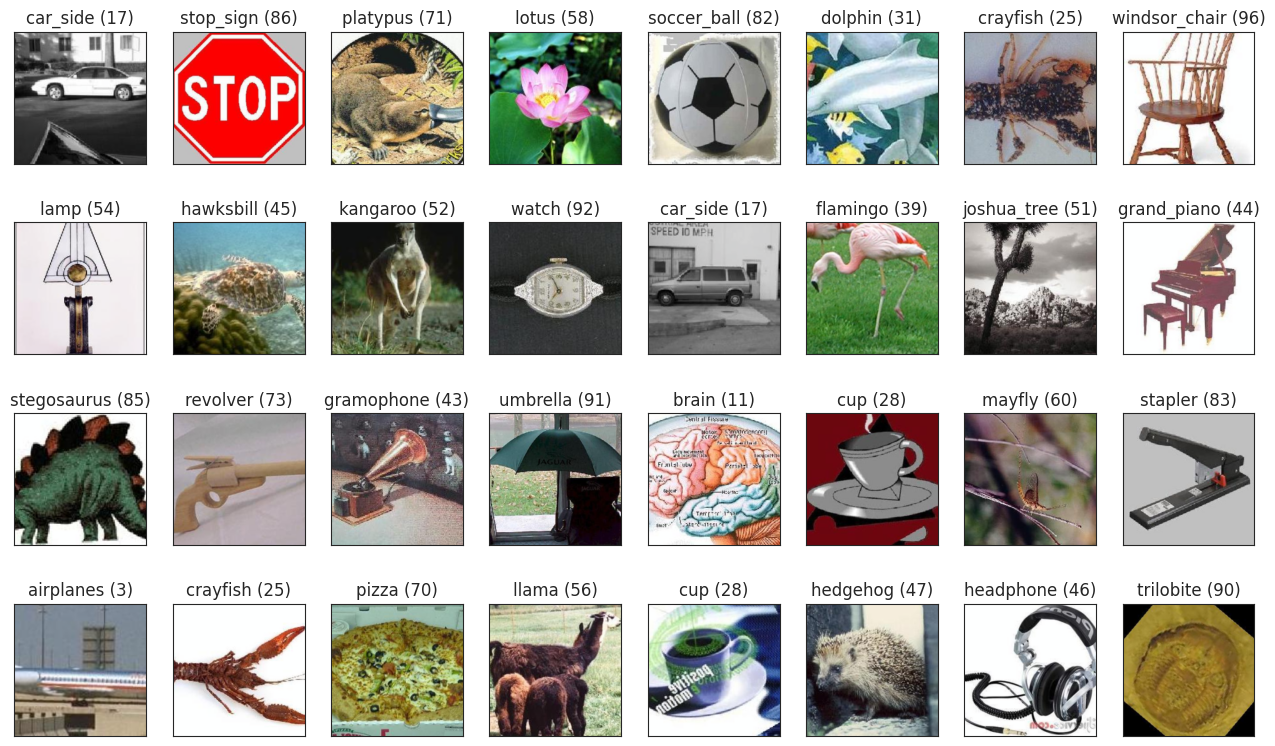

In [8]:
label_idxs, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(20, 4.2))
sns.barplot(x=[dataset.categories[keep_classes[label]] for label in label_idxs], y=counts, color=sns.color_palette('muted')[0])
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
      fig, axes = plt.subplots(4, 8, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten
    for j, (img, label) in enumerate(zip(images[:32], labels[:32])):
        plt.sca(axes[j])
        show_image(img, title=f"{dataset.categories[keep_classes[label.item()]]} ({label.item()})")
    plt.show()


print("\n\nTrain images (including augmentations):")
show_dataset_examples(train_loader)
print("\n\nTest images:")
show_dataset_examples(test_loader)

## Definir una Red Neuronal

**Asignación 1:** Adapta la CNN del laboratorio anterior (CIFAR-10) para manejar imágenes de 224x224. Recomendamos reducir significativamente el tamaño de los tensores antes de aplanarlos, añadiendo capas convolucionales con `stride > 1` o capas de [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) (pero también puedes considerar [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)).


In [9]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # [224 -> 112]
            nn.ReLU(),
            nn.MaxPool2d(2),                                       # [112 -> 56]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),           # [56 -> 56]
            nn.ReLU(),
            nn.MaxPool2d(2),                                       # [56 -> 28]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),          # [28 -> 28]
            nn.ReLU(),
            nn.MaxPool2d(2),                                       # [28 -> 14]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),         # [14 -> 14]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                           # [14x14 -> 1x1]
        )

        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        return self.classifier(x)

# Crear modelo para la asignación 1
model = CustomCNN(num_classes=len(np.unique(labels)))
model = model.to(device)
print(model)


CustomCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Linear(in_features=256, out_features=99, bias=True)
)


## Definir la Función de Pérdida y el Optimizador

**Asignación 2:** Implementa el criterio y el optimizador, como en el cuaderno anterior.

In [10]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Entrenar la red

In [11]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 224, 224).to(device))
print("Output shape:", out.size())

Output shape: torch.Size([2, 99])


In [12]:
# === Criterio y optimizador ===
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# === Configuraciones del entrenamiento ===
num_epochs = 10
validation_every_steps = 50

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        output = model(inputs)

        # Calcular la pérdida
        loss = loss_fn(output, targets)

        # Limpiar gradientes previos
        optimizer.zero_grad()

        # Calcular nuevos gradientes
        loss.backward()

        # Actualizar los pesos
        optimizer.step()

        step += 1

        # Calcular precisión
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:
            # Guardar precisión promedio en entrenamiento
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []

            # Evaluar en conjunto de prueba
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
                model.train()

            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")


Step 50      training accuracy: 0.024375
             test accuracy: 0.046875
Step 100     training accuracy: 0.060267857142857144
             test accuracy: 0.0703125
Step 150     training accuracy: 0.0684375
             test accuracy: 0.075
Step 200     training accuracy: 0.09933035714285714
             test accuracy: 0.0953125
Step 250     training accuracy: 0.099375
             test accuracy: 0.1140625
Step 300     training accuracy: 0.12462797619047619
             test accuracy: 0.1203125
Step 350     training accuracy: 0.1484375
             test accuracy: 0.14375
Step 400     training accuracy: 0.1403125
             test accuracy: 0.1578125
Step 450     training accuracy: 0.16640625
             test accuracy: 0.1703125
Step 500     training accuracy: 0.1728125
             test accuracy: 0.190625
Step 550     training accuracy: 0.1879595588235294
             test accuracy: 0.2078125
Step 600     training accuracy: 0.199375
             test accuracy: 0.2109375
Step 650  

# Evaluar la red en el conjunto de test

In [13]:
# Evaluate test set
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    print(f"Test accuracy: {test_accuracy:.3f}")

    model.train()

Test accuracy: 0.297


## Usando un Modelo Preentrenado

Aquí cargaremos un ResNet34 que fue preentrenado en ImageNet. Luego, descartaremos el clasificador lineal al final de la red (la "cabeza" de la red) y lo reemplazaremos con uno nuevo que produzca el número deseado de logits para la clasificación. Para obtener una idea general de la estructura del modelo, lo imprimimos a continuación.

El argumento `finetune_entire_model` en `initialize_model()` controla si se ajusta toda la red preentrenada. Cuando esto es `False`, solo se entrena la cabeza lineal y el resto del modelo se mantiene fijo. La idea es que las características extraídas por el modelo de ImageNet, hasta la capa de clasificación final, también son muy informativas en otros conjuntos de datos (ver, por ejemplo, [este artículo](https://arxiv.org/abs/1910.04867) sobre la transferibilidad de representaciones profundas en modelos de visión grandes).

Comenzaremos aquí entrenando solo la cabeza lineal. Puedes experimentar con diferentes modelos y variaciones.

A continuación, definimos el modelo y descartamos el que acabamos de entrenar. Después de eso, puedes volver a la sección "Definir la Función de Pérdida y el Optimizador" y volver a ejecutar el cuaderno desde allí, para entrenar y evaluar el nuevo modelo.


In [ ]:
def initialize_model(model_name: str, *, num_classes: int, finetune_entire_model: bool = False):
    """Returns a pretrained model with a new last layer, and a dict with additional info.

    The dict now contains the number of model parameters, computed as the number of
    trainable parameters as soon as the model is loaded.
    """

    print(
        f"Loading model '{model_name}', with "
        f"finetune_entire_model={finetune_entire_model}, changing the "
        f"last layer to output {num_classes} logits."
    )
    model = timm.create_model(
        model_name, pretrained=True, num_classes=num_classes
    )

    num_model_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_model_parameters += p.numel()

    if not finetune_entire_model:
        for name, param in model.named_parameters():
            param.requires_grad = False

        # Layer names are not consistent, so we have to consider a few cases. This might
        # break for arbitrary models from timm (we have not checked all available models).
        layer = None
        if hasattr(model, "classifier"):
            if isinstance(model.classifier, nn.Linear):
                layer = model.classifier
        elif hasattr(model, "head"):
            if isinstance(model.head, nn.Linear):
                layer = model.head
            elif hasattr(model.head, "fc") and isinstance(model.head.fc, nn.Linear):
                layer = model.head.fc
            elif hasattr(model.head, "l") and isinstance(model.head.l, nn.Linear):
                layer = model.head.l
        elif hasattr(model, "fc"):
            if isinstance(model.fc, nn.Linear):
                layer = model.fc
        if layer is None:
            raise ValueError(f"Couldn't automatically find last layer of model.")

        # Make the last layer trainable.
        layer.weight.requires_grad_()
        layer.bias.requires_grad_()

    num_trainable_model_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_trainable_model_parameters += p.numel()

    return model, {
        "num_model_parameters": num_model_parameters,
        "num_trainable_model_parameters": num_trainable_model_parameters,
    }

model, data = initialize_model('resnet34d', num_classes=len(np.unique(labels)), finetune_entire_model=False)

print(model)
print("Number of model parameters:", data["num_model_parameters"])
print("Number of trainable parameters:", data["num_trainable_model_parameters"])

device = torch.device('cuda')  # use cuda or cpu
model = model.to(device)

**Asignación 3:**

1. Entrena el clasificador lineal sobre la red preentrenada y observa qué tan rápido puedes obtener buenos resultados, en comparación con entrenar una red más pequeña desde cero como hicimos anteriormente.

2. Vuelve atrás y cambia el argumento para ajustar toda la red (`finetune_entire_model`), tal vez ajusta la tasa de aprendizaje, y observa si puedes obtener un mejor rendimiento que antes y si encuentras algún problema.

3. Opcional: experimenta con `timm`: prueba modelos más pequeños o más grandes, incluyendo modelos de última generación, por ejemplo, basados en transformadores de visión (ViT) o MLP-Mixers.

4. Describe brevemente lo que hiciste y cualquier experimento que realizaste, así como los resultados que obtuviste.
¿Algo te sorprendió durante el ejercicio?

5. Escribe las lecciones o ideas clave que obtuviste durante este ejercicio.
